# Sign Language Alphabet Recognition using MediaPipe & Random Forest

## 1. Project Overview

This project implements a **real-time sign language alphabet recognizer** using:

- **MediaPipe Hands** to extract 3D hand landmarks (21 points)
- A **Random Forest** classifier to recognize static hand signs
- A **webcam-based interface** for live prediction

We focus on **24 static letters** of the alphabet (excluding motion-based signs like *J* and *Z*), but the approach can be extended to more gestures and other sign languages.

### Objectives

- Collect a custom dataset of hand images for multiple letters
- Extract hand landmarks (x, y, z) using MediaPipe
- Train and evaluate a machine learning model
- Run a real-time demo that predicts the current sign from webcam video

---

In [56]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("ggplot")

os.makedirs("data/raw_images", exist_ok=True)
os.makedirs("models", exist_ok=True)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

print("Environment ready.")

Environment ready.


## 3. Data Collection (Image Capture)

We collect images for each letter class using the webcam.  
The user:

1. Chooses a letter (e.g. `A`, `B`, `C`, ...)
2. Runs the capture cell
3. Presses **`s`** to start automatic capturing
4. Holds the hand pose inside the green box

Images are saved under `data/raw_images/<LETTER>/`.


In [58]:
import time

SIGN_LABEL = "A"
NUM_IMAGES = 200 
CAPTURE_EVERY_N_FRAMES = 5

OUTPUT_DIR = f"data/raw_images/{SIGN_LABEL}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("ERROR: Cannot open webcam")

print(f"Ready to capture images for '{SIGN_LABEL}'.")
print("➡ Press 's' to START capturing")
print("➡ Press 'q' to QUIT")

started = False
count = 0
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    x1, y1 = int(w * 0.3), int(h * 0.2)
    x2, y2 = int(w * 0.7), int(h * 0.8)

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)

    if not started:
        text = "Press 's' to start capture"
        color = (0, 255, 255)
    else:
        text = f"{SIGN_LABEL}: {count}/{NUM_IMAGES}"
        color = (0, 255, 0)

    cv2.putText(frame, text, (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Capture Images", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("s") and not started:
        print("Starting capture...")
        started = True
        time.sleep(0.5)

    if key == ord("q"):
        print("Quit by user.")
        break

    if started and count < NUM_IMAGES:
        if frame_idx % CAPTURE_EVERY_N_FRAMES == 0:
            roi = frame[y1:y2, x1:x2]
            img_path = os.path.join(OUTPUT_DIR, f"{SIGN_LABEL}_{count}.jpg")
            cv2.imwrite(img_path, roi)
            count += 1
        frame_idx += 1

        if count >= NUM_IMAGES:
            print(f"Done capturing {NUM_IMAGES} images for {SIGN_LABEL}")
            break

cap.release()
cv2.destroyAllWindows()


Ready to capture images for 'A'.
➡ Press 's' to START capturing
➡ Press 'q' to QUIT
Quit by user.


## 4. Landmark Extraction with MediaPipe

In this step, we convert each captured image into a vector of **63 features**:

- 21 hand landmarks
- Each landmark has (x, y, z) coordinates

We store all samples in a single CSV file `data/dataset.csv` with:

- Feature columns: `f0, f1, ..., f62`
- Target column: `label`


In [52]:
RAW_DIR = "data/raw_images"
OUTPUT_CSV = "data/dataset.csv"

rows = []

with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
    for label in sorted(os.listdir(RAW_DIR)):
        folder = os.path.join(RAW_DIR, label)
        if not os.path.isdir(folder):
            continue
        print("Processing:", label)

        for img_file in os.listdir(folder):
            img_path = os.path.join(folder, img_file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img_rgb)

            if not result.multi_hand_landmarks:
                continue

            lm = result.multi_hand_landmarks[0]
            row = []

            for p in lm.landmark:
                row += [p.x, p.y, p.z]

            row.append(label)
            rows.append(row)

columns = [f"f{i}" for i in range(len(rows[0]) - 1)] + ["label"]
df = pd.DataFrame(rows, columns=columns)

df.to_csv(OUTPUT_CSV, index=False)
df

Processing: A
Processing: B
Processing: C
Processing: D
Processing: E
Processing: F
Processing: G
Processing: H
Processing: I
Processing: K
Processing: L
Processing: M
Processing: N
Processing: O
Processing: P
Processing: Q
Processing: R
Processing: S
Processing: T
Processing: U
Processing: V
Processing: W
Processing: X
Processing: Y


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,label
0,0.360409,0.880825,-1.340034e-06,0.540175,0.851121,-0.107426,0.699803,0.631480,-0.128132,0.777307,...,0.176895,0.371715,-0.092105,0.216128,0.491814,-0.050937,0.234192,0.521538,0.000193,A
1,0.346615,0.856648,-1.319659e-06,0.518180,0.822233,-0.089477,0.664916,0.608455,-0.103985,0.739117,...,0.170775,0.356091,-0.095534,0.209111,0.475201,-0.051867,0.228687,0.507658,-0.002906,A
2,0.388839,0.633886,-1.044532e-06,0.571113,0.587747,-0.053994,0.694238,0.413045,-0.057483,0.759695,...,0.261655,0.176334,-0.075027,0.285742,0.263406,-0.041926,0.302291,0.304562,-0.002121,A
3,0.164714,0.780317,-1.023541e-06,0.315124,0.732889,-0.025172,0.412396,0.603682,-0.022004,0.459785,...,0.088015,0.400561,-0.066156,0.107854,0.475417,-0.041073,0.108957,0.520183,-0.008642,A
4,0.150515,0.758441,-9.555329e-07,0.295143,0.710002,-0.028219,0.394731,0.588315,-0.027321,0.444437,...,0.075692,0.392285,-0.067821,0.097032,0.471486,-0.046125,0.100130,0.520828,-0.014450,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,0.296306,0.855778,1.612499e-07,0.436171,0.835810,-0.087438,0.556829,0.706052,-0.122628,0.533832,...,0.260866,0.351609,-0.131979,0.258848,0.265194,-0.143668,0.259966,0.166316,-0.140349,Y
4248,0.293524,0.865427,2.054570e-07,0.424278,0.842560,-0.089216,0.542029,0.716852,-0.128547,0.512977,...,0.239011,0.360768,-0.145564,0.234288,0.273668,-0.156868,0.231848,0.173827,-0.153282,Y
4249,0.286710,0.865284,2.971734e-07,0.418487,0.840615,-0.088709,0.535433,0.714802,-0.129584,0.510485,...,0.233765,0.355710,-0.146569,0.227009,0.267193,-0.154962,0.223102,0.165536,-0.149807,Y
4250,0.287795,0.875568,3.004648e-07,0.427757,0.846331,-0.088380,0.549868,0.714864,-0.126083,0.525324,...,0.242784,0.349830,-0.141283,0.239557,0.258792,-0.150787,0.237756,0.155707,-0.148070,Y


## 5. Exploratory Data Analysis (EDA)

We first inspect the class distribution to ensure that all letters have a reasonable number of samples.


label
A    182
B    199
C    173
D    165
E    172
F    199
G    106
H    118
I    200
K    131
L    189
M    162
N    174
O    156
P    152
Q    188
R    200
S    197
T    200
U    200
V    194
W    198
X    197
Y    200
Name: count, dtype: int64


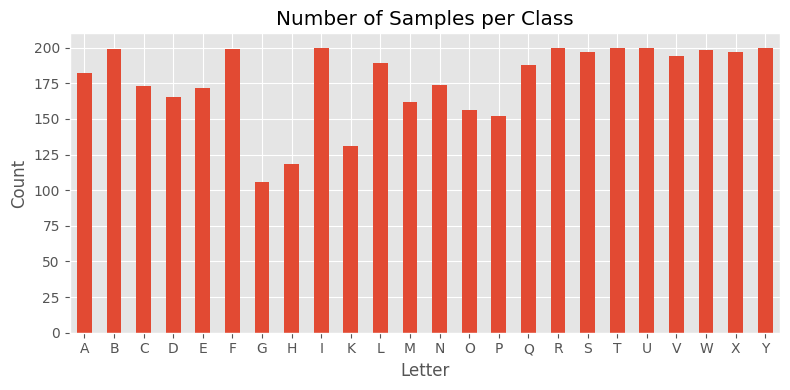

In [60]:
df = pd.read_csv("data/dataset.csv")

class_counts = df["label"].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(8,4))
class_counts.plot(kind="bar")
plt.title("Number of Samples per Class")
plt.xlabel("Letter")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 5.2 Visualizing Landmarks on Sample Images

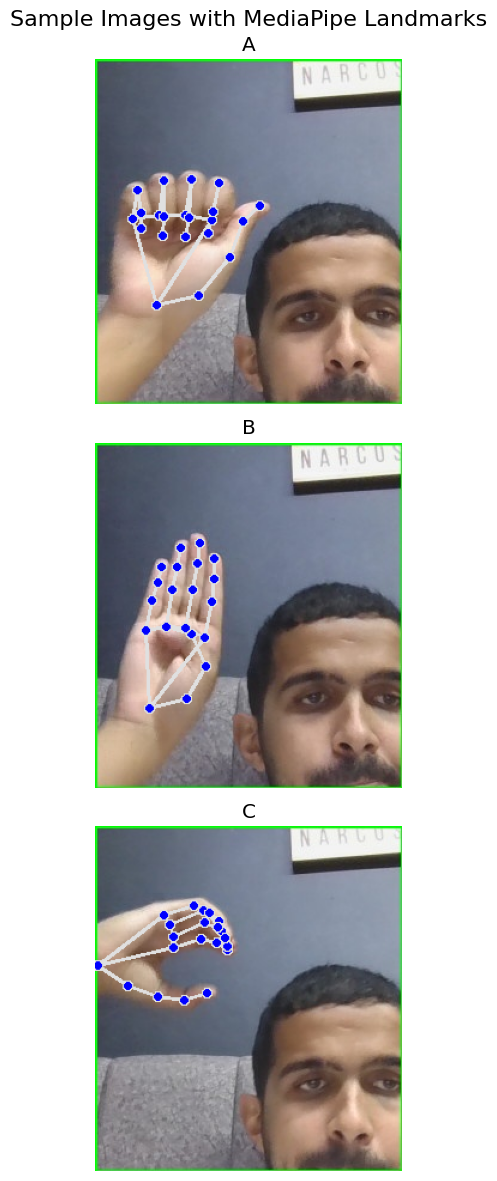

In [64]:
import random

RAW_DIR = "data/raw_images"

def visualize_landmarks_grid(labels=None, samples_per_label=3):
    if labels is None:
        labels = sorted([d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))])

    all_images = []

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        for label in labels:
            folder = os.path.join(RAW_DIR, label)
            img_files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
            if not img_files:
                continue

            chosen = random.sample(img_files, min(samples_per_label, len(img_files)))

            for img_name in chosen:
                img_path = os.path.join(folder, img_name)
                img_bgr = cv2.imread(img_path)
                if img_bgr is None:
                    continue

                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                result = hands.process(img_rgb)

                annotated = img_rgb.copy()
                if result.multi_hand_landmarks:
                    for hand_landmarks in result.multi_hand_landmarks:
                        mp_drawing.draw_landmarks(
                            annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS
                        )

                all_images.append((label, annotated))

    if not all_images:
        print("No images to display.")
        return

    cols = samples_per_label
    rows = int(np.ceil(len(all_images) / cols))

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, (label, img) in enumerate(all_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle("Sample Images with MediaPipe Landmarks", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_landmarks_grid(labels=["A", "B", "C"], samples_per_label=1)

## 6. Model Training & Evaluation

We train a **Random Forest** classifier on the landmark features.

We then:
- Print a classification report (precision, recall, f1-score)
- Plot a normalized confusion matrix

In [62]:
df = pd.read_csv("data/dataset.csv")

X = df.drop("label", axis=1).values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/classifier.pkl")
print("Model saved to models/classifier.pkl")


Training model...
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        36
           B       1.00      0.97      0.99        40
           C       0.94      0.97      0.96        35
           D       1.00      0.97      0.98        33
           E       0.97      1.00      0.99        34
           F       0.98      1.00      0.99        40
           G       1.00      1.00      1.00        21
           H       1.00      1.00      1.00        24
           I       1.00      1.00      1.00        40
           K       1.00      1.00      1.00        26
           L       1.00      0.97      0.99        38
           M       1.00      1.00      1.00        32
           N       1.00      1.00      1.00        35
           O       1.00      0.97      0.98        31
           P       1.00      1.00      1.00        30
           Q       1.00      1.00      1.00        38
           R       1.00      1.00      1

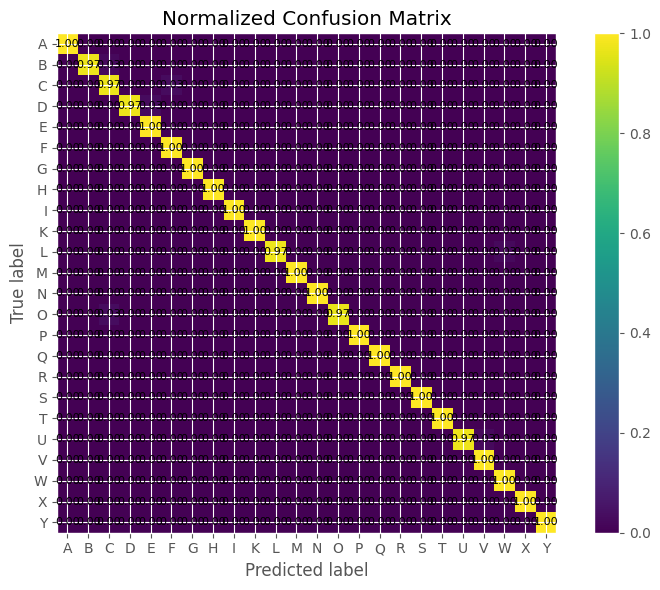

In [63]:
labels_sorted = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels_sorted))
plt.xticks(tick_marks, labels_sorted)
plt.yticks(tick_marks, labels_sorted)
plt.ylabel("True label")
plt.xlabel("Predicted label")

# add values in cells
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

## 7. Real-Time Inference Demo

In this final step, we:

- Load the trained model
- Open the webcam
- Detect hand landmarks in real time
- Predict the current letter and display it on the video feed

Press **`q`** to quit the demo.

In [54]:
clf = joblib.load("models/classifier.pkl")

cap = cv2.VideoCapture(0)

with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
) as hands:

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(img_rgb)

        label_text = "No Hand"

        if result.multi_hand_landmarks:
            lm = result.multi_hand_landmarks[0]
            mp_drawing.draw_landmarks(frame, lm, mp_hands.HAND_CONNECTIONS)

            coords = []
            for p in lm.landmark:
                coords += [p.x, p.y, p.z]

            pred = clf.predict([coords])[0]
            label_text = pred

        cv2.putText(frame, label_text, (10,40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 3)

        cv2.imshow("Real-time ASL Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()